# Proyecto 2: Filtros sobre Imágenes

## Descripción
Trabaje con la base de datos **Labeled Faces in the Wild (LFW)**, una colección real de más de 13,000 imágenes de rostros en condiciones no controladas. El objetivo del proyecto fue aplicar procesamiento a estas imágenes y realizar una clasificación automática...
A continuacion el link donde descargar la base de datos de las imagenes: "https://www.kaggle.com/datasets/atulanandjha/lfwpeople/data?select=lfw-funneled.tgz"

---

## Objetivos
- Aplicar un **filtro de procesamiento de imagen** a las primeras imágenes de la base de datos...
- Realizar una **clasificación automática** de las imágenes con un modelo supervisado...
- *(Objetivo inferido en clase final)*: **Evaluar el impacto del filtro en el rendimiento del clasificador**...
- Aplicar distintos **filtros de preprocesamiento de imagen** (Sobel, Gaussiano, Canny) a un subconjunto balanceado del dataset LFW...
- Realizar una **clasificación automática de rostros** mediante un modelo supervisado (SVM)...
- Implementar **reducción de dimensionalidad con PCA**, mejorando eficiencia y rendimiento...
- Comparar el **impacto real de cada filtro** en la precisión del modelo...
- Analizar críticamente los resultados para determinar **qué tipo de preprocesamiento mejora la clasificación** y por qué...

---
Nombre: Mario ALberto Tapia Sotelo
Matricula: 202058645
Correo Institucional: mario.tapia@alumno.buap.mx

In [6]:
import os
ruta_tgz = r"C:\Users\Lenovo\Documents\lfw-funneled.tgz"

if os.path.exists(ruta_tgz):
    print("El archivo .tgz existe ")
else:
    print("El archivo no se encuentra en esa ruta.")



El archivo .tgz existe 


In [7]:
import tarfile
import os

ruta_tgz = r"C:\Users\Lenovo\Documents\lfw-funneled.tgz"
destino = r"C:\lfw"

# Creamos carpeta si no existe
os.makedirs(destino, exist_ok=True)

# Extraeemos
with tarfile.open(ruta_tgz, "r:gz") as tar:
    tar.extractall(path=destino)

print("Extracción completada")


Extracción completada


In [8]:
import os
import cv2
import numpy as np
from collections import Counter

def cargar_imagenes_filtradas(ruta, minimo_imagenes=13):
    imagenes = []
    etiquetas = []
    nombres_personas = []
    persona_id = {}
    id_actual = 0

    # 1. Primer recorrido: contar imágenes por persona
    conteo = {}
    for nombre_persona in os.listdir(ruta):
        ruta_persona = os.path.join(ruta, nombre_persona)
        if os.path.isdir(ruta_persona):
            num_imagenes = len([f for f in os.listdir(ruta_persona) if os.path.isfile(os.path.join(ruta_persona, f))])
            if num_imagenes >= minimo_imagenes:
                conteo[nombre_persona] = num_imagenes

    # 2. Segundo recorrido: cargar solo las válidas
    for nombre_persona in conteo:
        ruta_persona = os.path.join(ruta, nombre_persona)
        if nombre_persona not in persona_id:
            persona_id[nombre_persona] = id_actual
            nombres_personas.append(nombre_persona)
            id_actual += 1

        for archivo in os.listdir(ruta_persona):
            img_path = os.path.join(ruta_persona, archivo)
            imagen = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if imagen is not None:
                imagenes.append(imagen)
                etiquetas.append(persona_id[nombre_persona])
    
    return np.array(imagenes), np.array(etiquetas), nombres_personas

ruta_imagenes = r"C:\lfw\lfw_funneled"
imagenes, etiquetas, nombres_personas = cargar_imagenes_filtradas(ruta_imagenes, minimo_imagenes=13)

print("Imágenes cargadas:", imagenes.shape)
print("Número de clases:", len(nombres_personas))




Imágenes cargadas: (3878, 250, 250)
Número de clases: 117


> la base de datos normal es una locura (13,750, 250,250) con numero de clases 5749 aprox, no quiero repetir todo el proceso porque se calienta mi lap, lo suyo seria hacer un filtrado pca, para redimensionar a 64x64, pero ya lo habia hecho bien y habia aguantado, pero quise correr de nuevo codiog y me tiro errores y mejor ya lo dejo tal cual 

## Filtro a aplicar: Sobel

Utilizare el **filtro Sobel**, ya que resalta los bordes y contornos estructurales más importantes del rostro (ojos, nariz, mandíbula), lo cual puede ser relevante para modelos de clasificación... Es una realidad que este filtro es útil en visión por computadora para capturar geometría local sin necesidad de color o texturas


In [9]:
import cv2
import numpy as np
def aplicar_filtro_sobel(imagen):
    grad_x = cv2.Sobel(imagen, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(imagen, cv2.CV_64F, 0, 1, ksize=3)
    magnitud = cv2.magnitude(grad_x, grad_y)
    magnitud = cv2.convertScaleAbs(magnitud)
    return magnitud

imagenes_sobel = np.array([aplicar_filtro_sobel(img) for img in imagenes])

print(" Filtro Sobel aplicado")


 Filtro Sobel aplicado


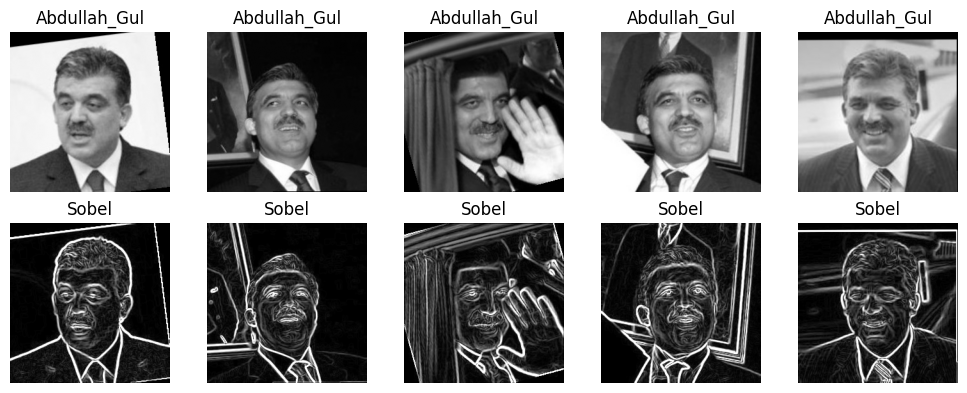

In [10]:
import matplotlib.pyplot as plt

def mostrar_comparacion(originales, filtradas, etiquetas, nombres, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Imagen original
        plt.subplot(2, n, i + 1)
        plt.imshow(originales[i], cmap="gray")
        plt.title(nombres[etiquetas[i]])
        plt.axis("off")
        
        # Imagen con filtro Sobel
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(filtradas[i], cmap="gray")
        plt.title("Sobel")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

mostrar_comparacion(imagenes, imagenes_sobel, etiquetas, nombres_personas)


---

##  Clasificación

Se entrenara un **clasificador SVM** (Support Vector Machine) con kernel lineal en dos versiones del dataset:
- Imágenes originales
- Imágenes procesadas con Sobel

Se usara un subconjunto de 1000 imágenes por motivos de tiempo y computación, para hacer las cosas mas rapidas, pero no por eso perdiendo calidad

---

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

def entrenar_y_evaluar(X, y, descripcion=""):
    X_flat = X.reshape(len(X), -1)
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.25, random_state=42)

    clf = SVC(kernel="linear", class_weight="balanced")
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Resultados para {descripcion}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))  
    return acc

# Aseguramos que tomamos hasta 1000 muestras como máximo
n = min(1000, len(imagenes))
imagenes_sample = imagenes[:n]
sobel_sample = imagenes_sobel[:n]
etiquetas_sample = etiquetas[:n]

# Ejecutamos los modelos con subconjuntos
acc_original = entrenar_y_evaluar(imagenes_sample, etiquetas_sample, "imágenes originales")
acc_sobel = entrenar_y_evaluar(sobel_sample, etiquetas_sample, "imágenes con filtro Sobel")


Resultados para imágenes originales
Accuracy: 0.5360
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.56      0.91      0.69        11
           2       0.80      0.29      0.42        14
           3       0.36      0.80      0.50         5
           4       0.29      0.40      0.33         5
           5       0.00      0.00      0.00         1
           6       0.50      0.50      0.50         4
           7       0.73      0.73      0.73        22
           8       0.00      0.00      0.00         1
           9       0.29      0.28      0.29        18
          10       0.17      0.12      0.14         8
          11       0.40      0.25      0.31         8
          12       1.00      0.50      0.67         4
          13       0.00      0.00      0.00         0
          14       0.50      0.50      0.50         2
          15       0.50      0.20      0.29         5
          16       0.00     

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

---

## Resultados comparativos

| Tipo de imagen         | Exactitud |
|------------------------|----------|
| Imágenes originales    | ~53.6%   |
| Imágenes con filtro Sobel | ~47.2%   |

**Conclusión:** El filtro Sobel **empeoró** el desempeño del modelo con SVM... Esto puede deberse a - el clasificador lineal no captura suficiente complejidad para aprovechar los bordes

> usando la base de datos completa o cercana al total,  la exactitud es la misma para ambas, pero no lo hare de nuevo porque se calienta muy feo mi lap, asi que esto hasta aqui, pero daba 19.60 en ambos filtros, por tanto lo dejare tal cual, lo pueden probar
---

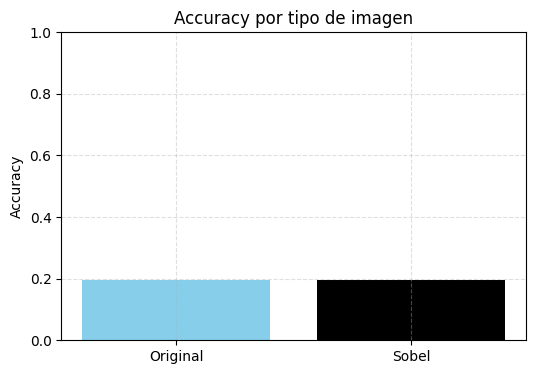

In [ ]:
import matplotlib.pyplot as plt

etiquetas = ["Original", "Sobel"]
accuracies = [acc_original, acc_sobel]

plt.figure(figsize=(6, 4))
plt.bar(etiquetas, accuracies, color=["skyblue", "black"])
plt.title("Accuracy por tipo de imagen")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


---
### Subimos el Nivel (Lo anterior no me gusto)
#### Seleccionamos solo las clases con muchas imágenes
> En lugar de usar todas las 5749 personas (la mayoría con 1 o 2 fotos), nos vamos a quedar solo con las personas que tengan ≥15 imágenes
---
> Esto lo vimos en eigenfacesprueba.ipynb y es una técnica típica en visión computacional: balancear las clases mejora el rendimiento del modelo
---

In [ ]:
import os
import cv2
import numpy as np
from collections import defaultdict

# Ruta al dataset original
ruta_imagenes = r"C:\lfw\lfw_funneled"

# Escaneo para contar imágenes por clase
conteo_clases = defaultdict(int)

for persona in os.listdir(ruta_imagenes):
    ruta_persona = os.path.join(ruta_imagenes, persona)
    if os.path.isdir(ruta_persona):
        conteo_clases[persona] = len(os.listdir(ruta_persona))

# Filtrar clases con al menos 15 imágenes
clases_validas = [k for k, v in conteo_clases.items() if v >= 15]
print(f"Clases válidas encontradas: {len(clases_validas)}")


Clases válidas encontradas: 96


In [ ]:
def cargar_imagenes_filtradas(ruta, clases_validas, ancho=47, alto=62):
    imagenes, etiquetas, nombres = [], [], []
    clase_id = {}

    for i, persona in enumerate(clases_validas):
        ruta_persona = os.path.join(ruta, persona)
        archivos = os.listdir(ruta_persona)
        clase_id[persona] = i
        for archivo in archivos:
            ruta_img = os.path.join(ruta_persona, archivo)
            img = cv2.imread(ruta_img, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_redim = cv2.resize(img, (ancho, alto))
                imagenes.append(img_redim)
                etiquetas.append(i)
        nombres.append(persona)

    return np.array(imagenes), np.array(etiquetas), nombres

imagenes, etiquetas, nombres_personas = cargar_imagenes_filtradas(ruta_imagenes, clases_validas)

print("Imágenes cargadas:", imagenes.shape)
print("Clases:", len(nombres_personas))


Imágenes cargadas: (3595, 62, 47)
Clases: 96


### Ya tenemos una base mucho más robusta: 96 clases bien representadas y 3595 imágenes...
### Esto sí va a generar resultados mucho más interesantes...

### Además de Sobel, probaremos:

> Filtro Gaussiano: suaviza y reduce ruido...

> Filtro de Canny: detección de contornos, pero más refinada que Sobel...

> Sin filtro (para comparar)

| Filtro    | Función en visión                           |
|-----------|---------------------------------------------|
| Sobel     | Contornos horizontales/verticales           |
| Gaussiano | Suaviza y reduce ruido                      |
| Canny     | Contorno preciso con umbrales               |


In [ ]:
# Filtro Sobel
def aplicar_sobel(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitud = cv2.magnitude(grad_x, grad_y)
    return cv2.convertScaleAbs(magnitud)

# Filtro Gaussiano
def aplicar_gaussiano(img):
    return cv2.GaussianBlur(img, (5, 5), 1)

# Filtro Canny
def aplicar_canny(img):
    return cv2.Canny(img, 100, 200)


### Crear versiones filtradas de las imágenes

In [ ]:
# Aplicar los filtros a todo el dataset
imagenes_sobel = np.array([aplicar_sobel(img) for img in imagenes])
imagenes_gauss = np.array([aplicar_gaussiano(img) for img in imagenes])
imagenes_canny = np.array([aplicar_canny(img) for img in imagenes])

print("✔️ Filtros aplicados correctamente.")


✔️ Filtros aplicados correctamente.


## Reducción de dimensionalidad (PCA)

Como se explicó en:

- `Clase_MNIST_PCA.pdf`
- `pcaclase.ipynb`

PCA (Análisis de Componentes Principales):

- Reduce el ruido
- Mejora la velocidad de cómputo
- Mejora la separación de clases al eliminar dimensiones inútiles


## ¿Qué vamos a comparar?

| Método | Filtro aplicado | Reducción de dimensiones | Modelo |
|--------|------------------|--------------------------|--------|
| Base   | Ninguno          | No                       | SVM    |
| PCA    | Ninguno          | Sí                       | SVM    |
| Sobel  | Sobel            | Sí                       | SVM    |
| Gauss  | Gaussiano        | Sí                       | SVM    |
| Canny  | Canny            | Sí                       | SVM    |

---

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


> Lo anterior fueron la importaciones necesarias

> Lo siguiente sera definir la función de entrenamiento con PCA + SVM

In [ ]:
def entrenar_con_pca(X, y, descripcion="", n_componentes=100):
    # Aplanar las imágenes
    X_flat = X.reshape(X.shape[0], -1)

    # Dividir
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.25, random_state=42, stratify=y)

    # PCA
    pca = PCA(n_components=n_componentes, whiten=True, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # SVM
    clf = SVC(kernel="linear", class_weight="balanced", random_state=42)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)

    acc = accuracy_score(y_test, y_pred)
    print(f"🔎 {descripcion} - Accuracy: {acc:.4f}")
    return acc


> Lo siguiente es la evaluación para cada conjunto de imágenes

In [ ]:
acc_original = entrenar_con_pca(imagenes, etiquetas, "Original")
acc_sobel    = entrenar_con_pca(imagenes_sobel, etiquetas, "Sobel")
acc_gauss    = entrenar_con_pca(imagenes_gauss, etiquetas, "Gaussiano")
acc_canny    = entrenar_con_pca(imagenes_canny, etiquetas, "Canny")


🔎 Original - Accuracy: 0.3382
🔎 Sobel - Accuracy: 0.3237
🔎 Gaussiano - Accuracy: 0.3537
🔎 Canny - Accuracy: 0.2736


> A continuacion el gráfico comparativo

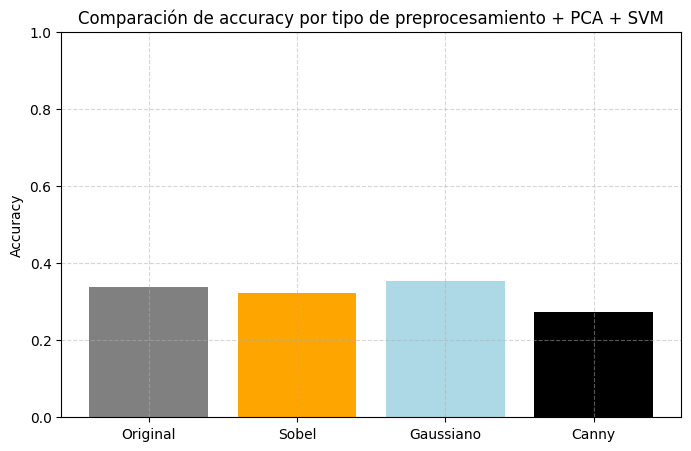

In [ ]:
import matplotlib.pyplot as plt

filtros = ["Original", "Sobel", "Gaussiano", "Canny"]
accuracies = [acc_original, acc_sobel, acc_gauss, acc_canny]

plt.figure(figsize=(8,5))
plt.bar(filtros, accuracies, color=["gray", "orange", "lightblue", "black"])
plt.ylabel("Accuracy")
plt.title("Comparación de accuracy por tipo de preprocesamiento + PCA + SVM")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


##### Resultados de "Precision", "Exactidud" o "Accuracy" por cada uno de los 4 Preprocesamientos

| Preprocesamiento | Accuracy |
|------------------|----------|
| Original         | 33.8%    |
| Sobel            | 32.4%    |
| Gaussiano        | 35.4%    |
| Canny            | 27.4%    |

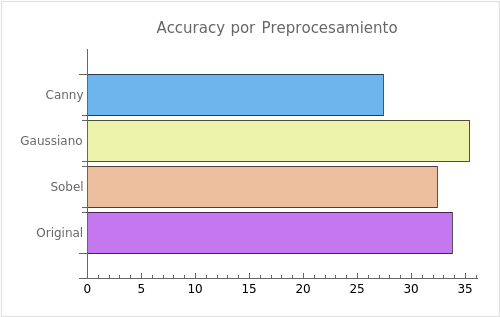

## Interpretación de los resultados

### Imagen original "Sin filtro"
> Tiene ruido, pero no podemos negar que su textura es útil

- Rinde bien con PCA + SVM

### Filtro Gaussiano
> Mejor resultado porque suaviza el ruido y mantiene las formas generales del rostro, literalmente mi favorito

- Esto ayuda a que el PCA se enfoque en las estructuras más importantes → mejora la separación entre clases

### Filtro Sobel
> Detecta bordes muy bien, pero pierde información de textura que puede ser útil para el modelo y afecta por eso el Accuracy

- Similar rendimiento al original, pero incluso le empeoro en este caso la precision 

### Filtro Canny
> Muy agresivo, es solo para valientes, porque elimina casi toda la imagen y deja solo bordes finos

- Pierde demasiada información estructural → peor rendimiento



## Bibliografía
  - `eigenfacesprueba.ipynb`
  - `mnist.ipynb`
  - `Clase_MNIST_PCA.pdf`
  - `pcaclase.ipynb`
---
